This notebook contains code butchered from my other projects - that's why it looks so messy and overly complicated.

In [57]:
from collections import defaultdict
from itertools import repeat
from concurrent.futures import ProcessPoolExecutor

import msprime as msp
import pandas as pd
import numpy as np
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [30]:
def years_to_gen(years, gen_time=25):
    return int(years / gen_time)


def nea_snps(snps):
    samples = snps.columns

    afr_freq = calc_freq(snps, list(samples[samples.str.startswith("yri")]) + list(samples[samples.str.startswith("dinka")]))
    nea_freq = calc_freq(snps, list(samples[samples.str.startswith("nea")]))

    return snps.loc[((afr_freq == 0) & (nea_freq == 1)) | ((afr_freq == 1) & (nea_freq == 0))]


def get_snps(tree_seq, samples):
    if isinstance(tree_seq, msp.TreeSequence):
        tree_seq = [tree_seq]
    
    return pd.concat(
        pd.DataFrame(
            ts.genotype_matrix(),
            columns=samples,
            index = (int(v.position) for v in ts.variants())
        ) for ts in tree_seq
    )


def generate_names(pop_params):
    samples = []
    for p in pop_params:
        samples.extend([p + str(i) for i in range(len(pop_params[p]["t_sample"]))])
    return samples


def define_samples(pop_params):
    samples = []
    for i, pop in enumerate(pop_params):
        times = [years_to_gen(t) for t in pop_params[pop]["t_sample"]]
        samples.extend([msp.Sample(population=i, time=t) for t in times])
    return samples


def define_popconfig(pop_params):
    return [msp.PopulationConfiguration(initial_size=pop_params[p]["Ne"]) for p in pop_params]

In [31]:
def get_sfs(freq, n_bins=100):
    freq_bins = pd.cut(freq,
                       bins = [i / n_bins for i in range(n_bins + 1)],
                       labels=range(1, n_bins + 1),
                       include_lowest=True) \
        .value_counts()
    return pd.DataFrame({"bin": freq_bins.index,
                         "count": freq_bins,
                         "prop": freq_bins / sum(freq_bins)}).sort_values("bin")


def calc_freq(snps, samples=None):
    if not samples:
        samples = list(snps.columns)

    if not isinstance(samples, list):
        samples = [samples]

    allele_counts = snps.loc[:, samples].sum(axis = 1)
    return allele_counts / len(samples)


def f4(snps, w, x, y, z):
    w_freq = calc_freq(snps, w)
    x_freq = calc_freq(snps, x)
    y_freq = calc_freq(snps, y)
    z_freq = calc_freq(snps, z)
    
    return ((w_freq - x_freq) * (y_freq - z_freq)).sum()


def f4_ratio(snps, x, a, b, c, o):
    return f4(snps, a, o, x, c) / f4(snps, a, o, b, c)


def d(snps, w, x, y, z):
    w_freq = calc_freq(snps, w)
    x_freq = calc_freq(snps, x)
    y_freq = calc_freq(snps, y)
    z_freq = calc_freq(snps, z)

    nom =  ((w_freq - x_freq) * (y_freq - z_freq)).sum()
    denom = ((w_freq + x_freq - 2 * w_freq * x_freq) * (y_freq + z_freq - 2 * y_freq * z_freq)).sum()

    return nom / denom

In [49]:
def run_sim(admix_params, pop_params, migr_params, seq_len, mut_rate=1e-8, debug=False, num_replicates=None):
    """Generic function for simulating Neandertal introgression."""
    CHIMP, YRI, DIN, NEA, EUR = [pop_params[p]["id"] for p in pop_params]

    # Neandertal admixture parameters
    admix_duration = years_to_gen(admix_params["duration"])
    admix_rate = admix_params["rate"] / admix_duration
    admix_start = years_to_gen(admix_params["t_admix"])
    admix_end = admix_start - admix_duration

    # population split times
    t_split_eur, t_split_dinka, t_split_nea, t_split_chimp = [years_to_gen(pop_params[p]["t_split"])
                                                             for p in ["eur", "dinka", "nea", "chimp"]]

    demography = [
        # EUR-AFR gene-flow
        msp.MigrationRateChange(time=0, rate=migr_params["eur_to_afr"], matrix_index=(DIN, EUR)),
        msp.MigrationRateChange(time=0, rate=2 * migr_params["eur_to_afr"], matrix_index=(YRI, EUR)),
        msp.MigrationRateChange(time=0, rate=migr_params["afr_to_eur"], matrix_index=(EUR, DIN)),

        # end of EUR-AFR gene-flow backwards in time
        msp.MigrationRateChange(time=years_to_gen(migr_params["t"]), rate=0.0, matrix_index=(DIN, EUR)),
        msp.MigrationRateChange(time=years_to_gen(migr_params["t"]), rate=0.0, matrix_index=(YRI, EUR)),
        msp.MigrationRateChange(time=years_to_gen(migr_params["t"]), rate=0.0, matrix_index=(EUR, DIN)),

        # Neanderthal admixture
        msp.MigrationRateChange(time=admix_end, rate=admix_rate, matrix_index=(EUR, NEA)),
        msp.MigrationRateChange(time=admix_start, rate=0, matrix_index=(EUR, NEA)),

        # population size during the bottleneck
        msp.PopulationParametersChange(time=admix_start, initial_size=pop_params["eur"]["bottle_Ne"], population_id=EUR),

        # out of Africa migration
        msp.MassMigration(time=t_split_eur, source=EUR, destination=DIN, proportion=1.0),

        # YRI-DIN split
        msp.MassMigration(time=t_split_dinka, source=DIN, destination=YRI, proportion=1.0),

        # Neanderthal split
        msp.MassMigration(time=t_split_nea, source=NEA, destination=YRI, proportion=1.0),

        # chimpanzee split
        msp.MassMigration(time=t_split_chimp, source=YRI, destination=CHIMP, proportion=1.0),
    ]

    samples = define_samples(pop_params)
    pop_config = define_popconfig(pop_params)

    # effective population sizes
    Ne0 = 10000

    if debug:
        msp.DemographyDebugger(
            Ne=Ne0,
            population_configurations=pop_config,
            demographic_events=demography
        ).print_history()
    else:
        return msp.simulate(
            length=seq_len,
            Ne=Ne0,
            mutation_rate=mut_rate,
            recombination_rate=1e-8,
            samples=samples,
            population_configurations=pop_config,
            demographic_events=demography,
            num_replicates=num_replicates
        )

Create a data frame with EMH and present-day EUR sample info (names and ages):

In [50]:
emh_ages = pd.read_csv("../data/emh_ages.txt", sep=" ", names=["name", "age"]).age

emh = pd.DataFrame({"name" : ["eur{}".format(i) for i in range(len(emh_ages))],
                    "age" : emh_ages})

n_present = 20
eur = pd.DataFrame({"name" : ["eur{}".format(i) for i in range(len(emh), len(emh) + n_present)],
                    "age" : list(repeat(0, n_present))})

samples = pd.concat([emh, eur]).reset_index(drop=True)
samples["post_admixture"] = 55000 - samples.age

In [51]:
admix_params = {
    "rate"     : 0.03,
    "t_admix"  : 55000,
    "duration" : 1000
}

pop_params = {
    "chimp" : {"id" : 0, "Ne" : 10000, "t_sample" : 1  * [0],     "t_split" : 6_000_000},
    "yri"   : {"id" : 1, "Ne" : 10000, "t_sample" : 50 * [0]},
    "dinka" : {"id" : 2, "Ne" : 10000, "t_sample" : 50 * [0],     "t_split" : 150_000},
    "nea"   : {"id" : 3, "Ne" : 1000,  "t_sample" : 4  * [70000], "t_split" : 500_000},
    "eur"   : {"id" : 4, "Ne" : 10000, "t_sample" : samples.age,  "t_split" : 60_000,    "bottle_Ne" : 2000}
}

In [52]:
def sim_stats(rep_id, t, afr_to_eur, eur_to_afr, seq_len=10_000, num_replicates=50_000):
    migr_params = { "t" : t, "afr_to_eur" : afr_to_eur, "eur_to_afr" : eur_to_afr }

    ts = run_sim(admix_params=admix_params, pop_params=pop_params, migr_params=migr_params,
                 seq_len=seq_len, num_replicates=num_replicates)

    snps = get_snps(ts, generate_names(pop_params))
    info_snps = nea_snps(snps)

    # samples used for admixture statistics
    dinka = ["dinka" + str(i) for i in range(50)]
    yri = ["yri" + str(i) for i in range(50)]
    altai = ["nea0", "nea1"]
    vindija = ["nea2", "nea3"]

    stats = defaultdict(list)
    for s in samples.name:
        stats["admix_prop"].append((info_snps[s] == info_snps.nea0).mean())
        stats["direct_f4"].append(f4_ratio(snps, s, a=altai, b=vindija, c=yri, o="chimp0"))
        stats["indirect_f4"].append(1 - f4_ratio(snps, s, a=yri, b=dinka, c=altai + vindija, o="chimp0"))
        stats["d_stat"].append(d(snps, w="eur0", x=s, y="dinka0", z="chimp0") if s != "eur0" else None)
    stats = pd.DataFrame(stats)

    stats["rep"] = rep_id
    stats["name"] = samples.name

    return stats

### Simulation test

In [58]:
%%time
admix_stats = sim_stats(rep_id=0, t=0, afr_to_eur=0.0, eur_to_afr=0.0)

CPU times: user 3h 38min 21s, sys: 22min 29s, total: 4h 50s
Wall time: 19min 31s


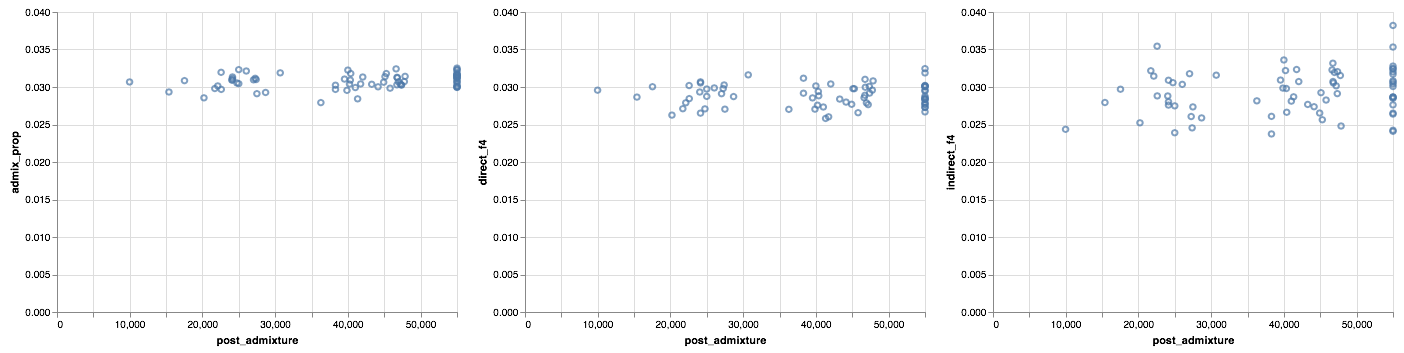

In [59]:
alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="admix_prop") \
    | alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="direct_f4") \
    | alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="indirect_f4")

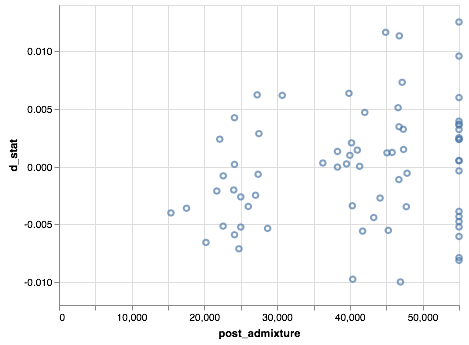

In [60]:
alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="d_stat")

In [61]:
%%time
admix_stats = sim_stats(rep_id=0, t=0, afr_to_eur=0.0, eur_to_afr=0.0, seq_len=100_000_000, num_replicates=1)

CPU times: user 46min 4s, sys: 47.9 s, total: 46min 52s
Wall time: 7min 25s


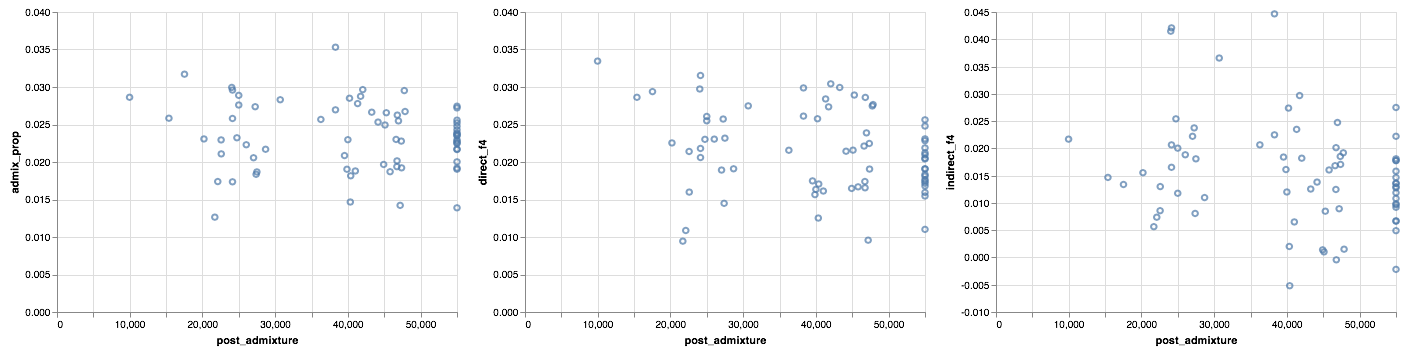

In [62]:
alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="admix_prop") \
    | alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="direct_f4") \
    | alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="indirect_f4")

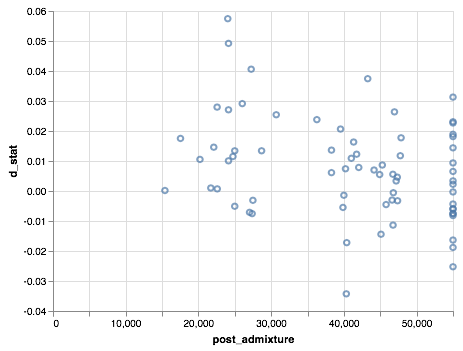

In [63]:
alt.Chart(pd.merge(samples, admix_stats, on="name")).mark_point().encode(x="post_admixture", y="d_stat")

## Run multiple replicates

In [53]:
reps = range(1, 6)
migr_rate = 0.0001
t_migr = 18_000

with ProcessPoolExecutor(10) as executor:
    no_flow    = pd.concat(executor.map(sim_stats, reps, repeat(t_migr), repeat(0),         repeat(0)))
    afr_to_eur = pd.concat(executor.map(sim_stats, reps, repeat(t_migr), repeat(0),         repeat(migr_rate)))
    eur_to_afr = pd.concat(executor.map(sim_stats, reps, repeat(t_migr), repeat(migr_rate), repeat(0)))
    both       = pd.concat(executor.map(sim_stats, reps, repeat(t_migr), repeat(migr_rate), repeat(migr_rate)))
    
    no_flow["scenario"] = "no_flow"
    afr_to_eur["scenario"] = "afr_to_eur"
    eur_to_afr["scenario"] = "eur_to_afr"
    both["scenario"] = "both"

stats_df = pd.concat([no_flow, afr_to_eur, eur_to_afr, both])

In [54]:
df = pd.merge(samples, stats_df, on="name")

In [55]:
df.head()

,name,age,post_admixture,admix_prop,direct_f4,indirect_f4,d_stat,rep,scenario
0,eur0,45020,9980,0.033285,0.030105,0.038364,NaN,1,no_flow
1,eur0,45020,9980,0.032750,0.031144,0.031667,NaN,2,no_flow
2,eur0,45020,9980,0.031850,0.030111,0.026585,NaN,3,no_flow
3,eur0,45020,9980,0.032581,0.031457,0.024335,NaN,4,no_flow
4,eur0,45020,9980,0.032832,0.027838,0.037445,NaN,5,no_flow


In [56]:
df.to_csv("../data/simulated_stats_0.3_Ne_10k_dinka_more.tsv", sep="\t", index=False)

In [ ]:
mean_stats = sims.groupby(by=["name", "post_admixture", "scenario"]).agg({"admix_prop" : np.mean, "direct_f4" : np.mean, "indirect_f4" : np.mean})

In [ ]:
sims = sims.melt(id_vars=["name", "age", "post_admixture", "rep", "scenario"], value_vars=["admix_prop", "direct_f4", "indirect_f4", "d"], var_name="stat")

In [ ]:
sims.head()

In [ ]:
ts = run_sim(admix_params, pop_params, migr_params, emh_ages, seq_len=1_000_000, recomb_rate=1e-8)

In [ ]:
snps = get_snps(ts, generate_names(pop_params, emh_ages))

In [ ]:
info_snps = nea_snps(snps)

In [ ]:
dinka = ["dinka" + str(i) for i in range(4)]
yri = ["yri" + str(i) for i in range(4)]
altai = ["nea0", "nea1"]
vindija = ["nea2", "nea3"]

In [ ]:
samples = pd.DataFrame({
    "name" : ["eur" + str(i) for i in range(pop_params["eur"]["n"])] +  ["emh" + str(i) for i in range(len(emh_ages))],
    "age" : [0] * pop_params["eur"]["n"] + emh_ages
})

samples["post_admixture"] = 2200 - samples.age / 25

In [ ]:
samples["admix_prop"] = info_snps.mean().values

In [ ]:
samples["direct_f4"] = pd.Series(f4_ratio(snps, x, a=altai, b=vindija, c=yri, o="chimp0") for x in samples.name)

In [ ]:
samples["indirect_f4"] = 1 - pd.Series(f4_ratio(snps, x, a=dinka, b=yri, c=altai + vindija, o="chimp0") for x in samples.name)
samples["flip_indirect_f4"] = 1 - pd.Series(f4_ratio(snps, x, a=yri, b=dinka, c=altai + vindija, o="chimp0") for x in samples.name)

In [ ]:
samples.head()